In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This notebook contains code to reproduce the following from Mitra, et al.:

* Extended Data Fig. 4: Power analysis

# ED Fig. 4a: power with existing sample size

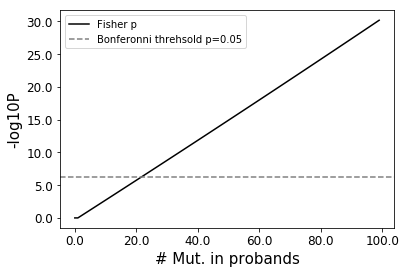

In [3]:
import os
import scipy.stats
OUTDIR="pdfs"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Contingency tables will have: status(0/1) x mutation(0/1)
# First, for different numbers of families, see how many mutations
# we need to see in probands (with 0 in controls) for genome-wide significance

NUMLOCI = 95000 # approx num loci with at least one mutation
NUMMUTS = range(100)
NVALS = [1593] # sample size
power_vals = {} # N -> vals

for N in NVALS:
    # For each N, test different numbers of muts in proband
    pvals = []
    for aff_mut in NUMMUTS:
        table = [[aff_mut, 0], [N-aff_mut, N]]
        p = scipy.stats.fisher_exact(table)[1]
        pvals.append(p)
    power_vals[N] = pvals

fig = plt.figure()
ax = fig.add_subplot(111)
N = NVALS[0] # Just plot for one sample size, since all look the same
ax.plot(NUMMUTS, [-1*np.log10(item) for item in power_vals[N]], label="Fisher p", color="black")
ax.axhline(y=-1*np.log10(0.05/NUMLOCI), color="gray", linestyle="dashed", label="Bonferonni threhsold p=0.05")
ax.set_xlabel("# Mut. in probands", size=15)
ax.set_ylabel("-log10P", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.legend()
fig.savefig(os.path.join(OUTDIR, "SuppFigure_Power.pdf"))

In [8]:
len([item for item in power_vals[1593] if item >0.05/NUMLOCI])

22

# ED Fig. 4b: power for differnt sample sizes

prev=1e-05
prev=0.0001
prev=0.0005
prev=0.001
prev=0.003


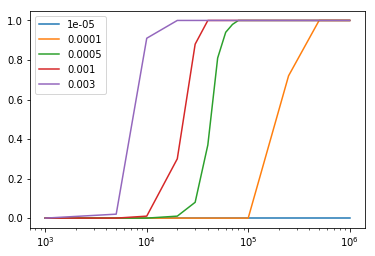

In [14]:
# Figure: Add new plot: X-axis sample size, y-axis power. Different line for rate in cases.

SAMPSIZE = [1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 250000, 500000, 750000, 1000000]
PREV = [0.00001, 0.0001, 0.0005, 0.001, 0.003]
niter = 100

pthresh = 0.05/NUMLOCI

fig = plt.figure()
ax = fig.add_subplot(111)

for pr in PREV:
    print("prev=%s"%pr)
    power = []
    for ssize in SAMPSIZE:
        pvals = []
        for i in range(niter):
            aff_mut = np.random.binomial(ssize, pr)
            table = [[aff_mut, 0], [ssize-aff_mut, ssize]]
            p = scipy.stats.fisher_exact(table)[1]
            pvals.append(p)
        power.append(np.mean([item<pthresh for item in pvals]))
    ax.plot(SAMPSIZE, power, label=pr)
plt.xscale("log")
ax.legend(loc="upper left")
fig.savefig(os.path.join(OUTDIR, "SuppFigure_Power_SampleSize.pdf"))

# ED Fig. 4c: QQ plot for burden tests

974004
648925


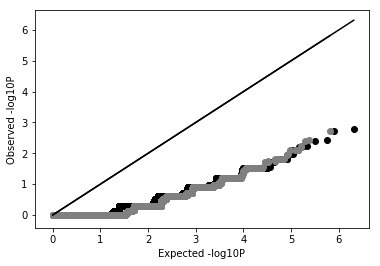

In [13]:
import pandas as pd

# Load annotation info
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Load per-locus mutation info. Annotate with period
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Aug20.locus_stats_rmoutlierfams.tab"

data = pd.read_csv(LOCFILE, delim_whitespace=True)
data = pd.merge(data, annot[["chrom","pos","period"]], how="left", on=["chrom","pos"])

print(data.shape[0])
print(data[data["period"]>1].shape[0])

def QQPlot(pvals, ax, color="black"):
    y_pvals = -1*np.log10(sorted(pvals))
    x_pvals = -1*np.log10(sorted(list(np.random.uniform(size=len(pvals)))))
    ax.scatter(x_pvals, y_pvals, color=color)
    maxval = max(max(y_pvals), max(x_pvals))
    ax.plot([0,maxval],[0,maxval], color="black")

fig = plt.figure()
ax = fig.add_subplot(111)
QQPlot(list(data[~np.isnan(data["fisher_p"])]["fisher_p"]), ax, color="black")
QQPlot(list(data[(~np.isnan(data["fisher_p"])) & (data["period"]>1)]["fisher_p"]), ax, color="gray")
ax.set_xlabel("Expected -log10P")
ax.set_ylabel("Observed -log10P")
fig.savefig(os.path.join(OUTDIR, "EDFig4_QQPlot_burden_P.png"))